# A. Data Wrangling

# 1. Purpose of This Data Science Project

The purpose of this data science project is to develop a pricing model for rents listed on rental postings. Property owners would benefit from listing their property at an appropriate price and in line with their position in the market. Owners would also benefit from insights to high-value versus low-value features.

# 2. Import Packages

In [1]:
pip install -U seaborn

Requirement already up-to-date: seaborn in c:\users\zebin\anaconda3\lib\site-packages (0.11.1)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.options.display.max_columns = None
import missingno as msno
import pandas_profiling
from pandas_profiling.utils.cache import cache_file
from collections import defaultdict
from datetime import datetime
from fuzzywuzzy import process, fuzz
import itertools

C:\Users\zebin\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# 3. Objectives of This Notebook

- To determine if the data we have could be use to develop a pricing model
    - Verify that there is an appropriate target feature
    - Verify that there are potentially useful features
- Verify that there are not fundamental issues with the data

# 4. Loading Data

In [3]:
immo_data= pd.read_csv('../data/raw/immo_data.csv')

In [4]:
rentals = immo_data.copy()

In [5]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

In [6]:
rentals.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,840.0,1965.0,96107057,1.0,oil,False,Nordrhein_Westfalen,True,2.0,595.0,244,86.00,Dortmund,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.4,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,NaN,1871.0,111378734,2.0,gas,False,Rheinland_Pfalz,False,1.0,800.0,NaN,89.00,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,1300.0,2019.0,113147523,1.0,NaN,False,Sachsen,True,9.0,965.0,4,83.80,Dresden,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,NaN,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,NaN,1964.0,108890903,NaN,district_heating,False,Sachsen,False,2.0,343.0,35,58.15,Mittelsachsen_Kreis,NaN,NaN,NaN,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,False,2,other,9599,3.0,86.0,3.0,NaN,3,False,2,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,903.0,1950.0,114751222,NaN,gas,False,Bremen,False,1.0,765.0,10,84.97,Bremen,refurbished,NaN,NaN,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,False,5,apartment,28213,3.0,188.9,1.0,NaN,3,False,4,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


# 5. Explore Data

## 5.1 Datetime Features

- We observed that certain features were dates. We will convert these features to a datetime format

In [7]:
#Convert yearConstructed, lastRefurbish and date to datetime
rentals.yearConstructed = pd.to_datetime(rentals.yearConstructed, format = '%Y', errors = 'coerce')
rentals.lastRefurbish = pd.to_datetime(rentals.lastRefurbish, format = '%Y', errors = 'coerce')
rentals.date = pd.to_datetime(rentals.date, format = '%b%y')

In [8]:
#Verify datetime features
rentals.select_dtypes(include=[np.datetime64]).head(3)

,yearConstructed,lastRefurbish,date
0,1965-01-01,NaT,2019-05-01
1,1871-01-01,2019-01-01,2019-05-01
2,2019-01-01,NaT,2019-10-01


## 5.2 Crossfield Validation of Price-related Features 

- Data owner noted that totalRent was the sum of baseRent, serviceCharge and heatingCosts. Let us review these features to determine which rows adhere to this formula

In [9]:
#Create dataframe with baseRent, serviceCharge, heatingCosts and totalRent features that have complete values
crossfield_cols = ['baseRent', 'serviceCharge', 'heatingCosts', 'totalRent']
crossfield = rentals.loc[:, crossfield_cols].dropna(axis =0)
crossfield.head()

,baseRent,serviceCharge,heatingCosts,totalRent
7,452.25,88.0,44.00,584.25
13,950.00,200.0,100.00,1150.00
14,972.60,215.0,43.05,1320.65
17,200.00,50.0,75.00,325.00
19,1343.48,290.0,160.00,1878.48


In [10]:
#Create series that sums baseRent, serviceCharge and heatingCosts
price_sum = crossfield[['baseRent', 'serviceCharge', 'heatingCosts']].sum(axis = 1)
price_sum.head()

7      584.25
13    1250.00
14    1230.65
17     325.00
19    1793.48
dtype: float64

In [11]:
#Create filter that compares the price_sum to totalRent
validated_sum = price_sum == crossfield['totalRent']
print(validated_sum.sum())
#Create crossfield dataframe with valid rows
validated_crossfield = crossfield.loc[validated_sum]
validated_crossfield.head()

49886


,baseRent,serviceCharge,heatingCosts,totalRent
7,452.25,88.0,44.0,584.25
17,200.00,50.0,75.0,325.00
20,1150.00,140.0,160.0,1450.00
48,870.00,121.5,121.5,1113.00
50,285.00,50.0,42.0,377.00


In [12]:
#Create dataframe with complete price information
rentals_allPrice = rentals.loc[list(validated_crossfield.index),:]
rentals_allPrice.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
7,Bremen,88.0,central_heating,ONE_YEAR_FREE,10.0,False,True,5,1.89,2.4,584.25,1959-01-01,115270775,NaN,gas:electricity,False,Bremen,True,2.0,452.25,35,60.30,Bremen,NaN,NaN,NaN,Lesumer Heerstr.,Lesumer_Heerstr.,False,3,ground_floor,28717,3.0,63.0,NaN,NaN,3,False,2,Bremen,St._Magnus,+ Komfortabler Bodenbelag: Die Wohnung ist zus...,Rollläden; Warmwasserbereiter; Kellerraum; Gas...,44.0,B,NaT,NaN,NaN,2020-02-01
17,Sachsen,50.0,central_heating,ONE_YEAR_FREE,NaN,False,False,12,1.96,40.0,325.00,1897-01-01,107018003,NaN,gas,False,Sachsen,False,1.0,200.00,NaN,50.00,Mittelsachsen_Kreis,refurbished,normal,NaN,no_information,NaN,False,1,roof_storey,4720,2.0,257.5,3.0,NaN,2,True,2,Mittelsachsen_Kreis,Döbeln,Vermietet wird eine gemütliche Wohnung mit zwe...,NaN,75.0,NaN,1996-01-01,90.76,0.2055,2018-09-01
20,Schleswig_Holstein,140.0,central_heating,ONE_YEAR_FREE,NaN,False,True,15,5.00,10.0,1450.00,1978-01-01,110416311,2.0,gas,False,Schleswig_Holstein,True,3.0,1150.00,NaN,160.00,Neumünster,well_kept,sophisticated,negotiable,no_information,NaN,False,7,ground_floor,24539,4.0,187.0,0.0,2.0,4,True,7,Neumünster,Wittorf,"Ihre repräsentative, großzügige und helle Wohn...",Das große Wohnzimmer wurde mit hochwertigem La...,160.0,NaN,NaT,NaN,NaN,2019-10-01
48,Schleswig_Holstein,121.5,NaN,NaN,NaN,True,True,2,3.90,NaN,1113.00,2019-01-01,113054252,NaN,pellet_heating,True,Schleswig_Holstein,False,9.0,870.00,21a,81.00,Steinburg_Kreis,NaN,NaN,NaN,Hinterstra&szlig;e,Hinterstraße,False,6,NaN,25379,3.0,65.0,2.0,2.0,3,False,4,Steinburg_Kreis,Herzhorn,Das moderne Mehrfamilienhaus im Herzen von He...,Aufzug• Ebenerdiges Dusche im Vollbad • Hochw...,121.5,B,NaT,NaN,NaN,2019-10-01
50,Brandenburg,50.0,central_heating,ONE_YEAR_FREE,NaN,False,True,7,4.20,40.0,377.00,1980-01-01,115654986,NaN,gas,False,Brandenburg,True,3.0,285.00,19,36.29,Oder_Spree_Kreis,fully_renovated,normal,negotiable,Gottfried-Keller Str.,Gottfried-Keller_Str.,True,1,apartment,15517,1.0,147.0,1.0,7.0,1,False,1,Oder_Spree_Kreis,Fürstenwalde/Spree,NaN,"Bad mit Badewanne, Balkon und neue Bodenbeläge...",42.0,NaN,2019-01-01,NaN,NaN,2020-02-01


In [13]:
pct_info_loss = (1 - rentals_allPrice.shape[0]/ rentals.shape[0]) * 100
print('We lose % .2f%% of our data if we only use rows that have full price information'%(pct_info_loss))

We lose  81.44% of our data if we only use rows that have full price information


- If there were more rows with totalRent, we would not need the other price-related features for our modelling because the baseRent and utility costs would be captured in the totalRent. It is most likely the case that utility costs like heatingCosts and serviceCharge had missing values because they are typically variable costs that depend on consumption.

## 5.3 Reviewing Data Completeness

In [14]:
#To determine counts and percentage of valid entries
missing = pd.concat([rentals.isnull().sum(), rentals.isnull().mean() * 100], axis = 1)
missing.columns = ['num_mssg', 'pct_mssg']
missing.sort_values(by = 'num_mssg', ascending = False)

,num_mssg,pct_mssg
telekomHybridUploadSpeed,223830,83.254603
electricityKwhPrice,222004,82.575414
electricityBasePrice,222004,82.575414
energyEfficiencyClass,191063,71.066766
lastRefurbish,188145,69.981402
heatingCosts,183332,68.191185
noParkSpaces,175798,65.388879
petsAllowed,114573,42.615957
interiorQual,112665,41.906267
thermalChar,106506,39.615399


- Let's view the completeness count and fraction of bottom twenty features

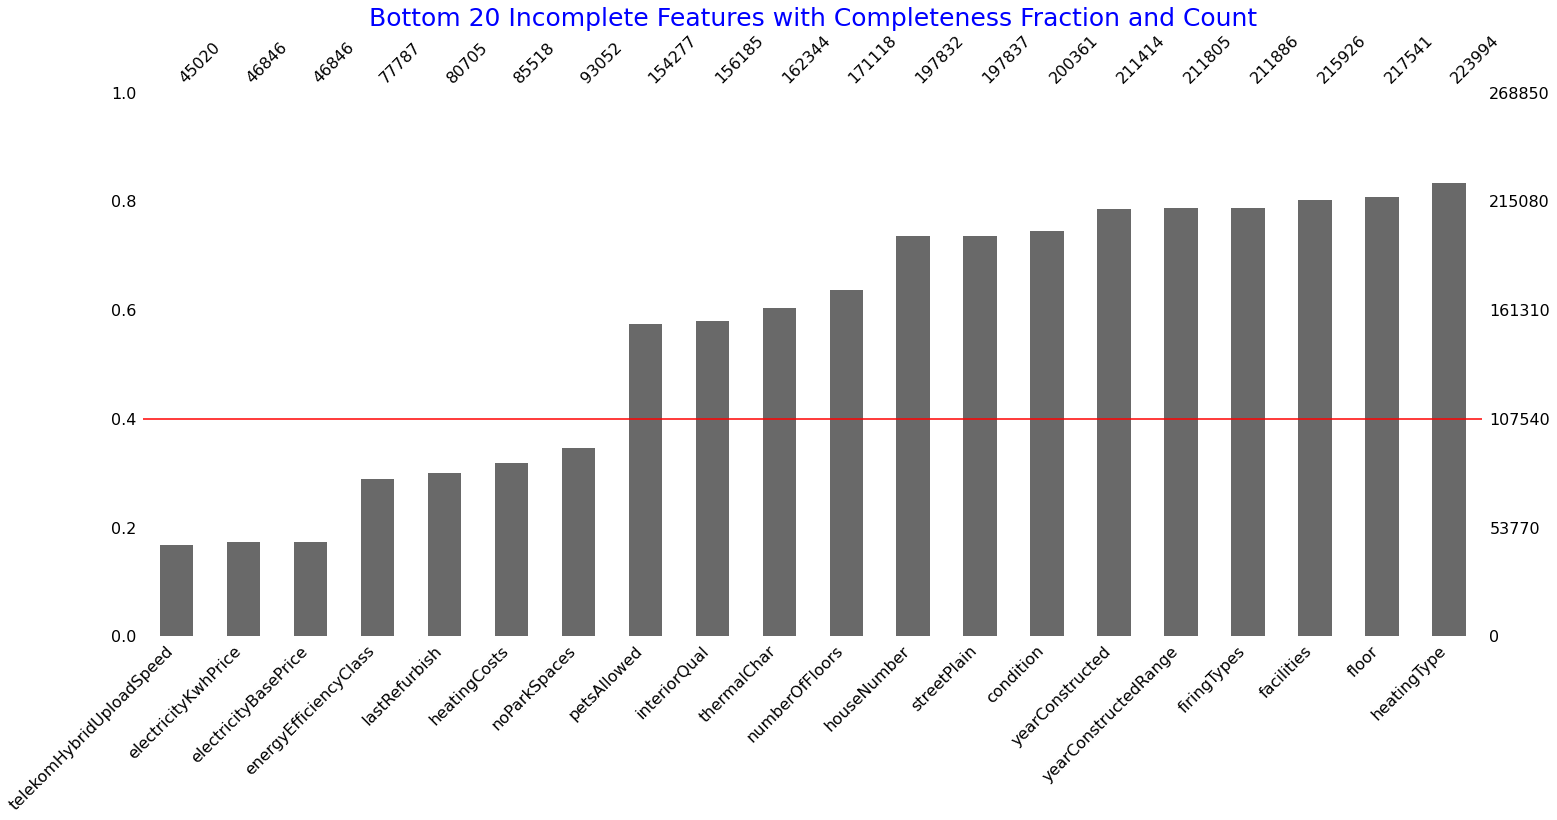

In [15]:
_= msno.bar(rentals,filter = 'bottom', n = 20, sort = 'ascending')
_= plt.axhline(y=0.4, color='r', linestyle='-')
_= plt.title('Bottom 20 Incomplete Features with Completeness Fraction and Count', fontsize = 25, color = 'blue')

- There are seven features that are less than 40% complete, including heatingCosts and electricityKwhPrice. We will filter-out these features from the dataframe.

In [16]:
#Filter-out features with over 40% missing values
rentals = msno.nullity_filter(rentals,filter = 'top', p =0.4)
rentals.shape

(268850, 42)

## 5.4 Checking for Duplicated Rental Units 

In [17]:
#Check for duplicates across all columns except scoutId which is the unique identifier for each listing
rentals_noScoutId = rentals.loc[:, rentals.columns != 'scoutId']
duplicates = rentals_noScoutId.duplicated()
duplicates.sum()

900

-There are potentially 900 duplicated rows. We will review the nature of the duplicated rows

In [18]:
subset = ['houseNumber', 'streetPlain','regio3', 'regio2','regio1','geo_plz', 'baseRent', 'totalRent', 'noRooms']
full_duplicates = rentals_noScoutId.duplicated(keep = False)
rentals.loc[full_duplicates, subset].sort_values(by = ['regio3', 'streetPlain']).head(20)

,houseNumber,streetPlain,regio3,regio2,regio1,geo_plz,baseRent,totalRent,noRooms
122607,NaN,NaN,Aachen_Eilendorf,Aachen,Nordrhein_Westfalen,52080,650.00,NaN,3.0
135689,NaN,NaN,Aachen_Eilendorf,Aachen,Nordrhein_Westfalen,52080,650.00,NaN,3.0
54879,NaN,NaN,Abensberg,Kelheim_Kreis,Bayern,93326,600.00,750.00,2.0
226122,NaN,NaN,Abensberg,Kelheim_Kreis,Bayern,93326,600.00,750.00,2.0
25677,27,Dörpfeldstraße,Adlershof_Treptow,Berlin,Berlin,12489,1330.00,1710.00,5.0
86827,5,Dörpfeldstraße,Adlershof_Treptow,Berlin,Berlin,12489,621.35,763.05,1.0
207406,5,Dörpfeldstraße,Adlershof_Treptow,Berlin,Berlin,12489,621.35,763.05,1.0
235965,27,Dörpfeldstraße,Adlershof_Treptow,Berlin,Berlin,12489,1330.00,1710.00,5.0
267457,27,Dörpfeldstraße,Adlershof_Treptow,Berlin,Berlin,12489,1330.00,1710.00,5.0
26652,NaN,NaN,Adlershof_Treptow,Berlin,Berlin,12489,600.00,700.00,2.0


- We will drop duplicated rows

In [19]:
column_names = rentals.loc[:, rentals.columns != 'scoutId'].columns

In [20]:
rentals.shape

(268850, 42)

In [21]:
rentals.drop_duplicates(subset = column_names, inplace = True)
rentals.shape

(267950, 42)

## 5.5 Reviewing Categorical Features
    
### 5.5.1 Address Information <br>(houseNumber, geo_bln, geo_krs, street, geo_plz, regio1, regio2,    regio3, streetPlain)</br>

In [22]:
address = ['houseNumber','street', 'streetPlain', 'regio3', 'regio2','geo_krs','regio1', 'geo_bln', 'geo_plz']
rentals[address].head()

,houseNumber,street,streetPlain,regio3,regio2,geo_krs,regio1,geo_bln,geo_plz
0,244,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,Schüren,Dortmund,Dortmund,Nordrhein_Westfalen,Nordrhein_Westfalen,44269
1,NaN,no_information,NaN,Böhl_Iggelheim,Rhein_Pfalz_Kreis,Rhein_Pfalz_Kreis,Rheinland_Pfalz,Rheinland_Pfalz,67459
2,4,Turnerweg,Turnerweg,Äußere_Neustadt_Antonstadt,Dresden,Dresden,Sachsen,Sachsen,1097
3,35,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,Freiberg,Mittelsachsen_Kreis,Mittelsachsen_Kreis,Sachsen,Sachsen,9599
4,10,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,Neu_Schwachhausen,Bremen,Bremen,Bremen,Bremen,28213


- We notice that street seems identical to streetPlain, regio2 seems identical to geo_krs and regio1 seems identical to geo_bln
- We will review these relationships

In [23]:
#Check if there are records where regio1 is not identical to geo_bln 
(rentals["regio1"] != rentals['geo_bln']).sum() 

0

- regio1 is the state and it is always equal to geo_bln. We will drop geo_bln

In [24]:
#Number of categories
rentals.regio1.nunique()

16

In [25]:
#Review category names and how many records in which they appear
rentals.regio1.value_counts()

Nordrhein_Westfalen       62744
Sachsen                   57848
Bayern                    21566
Sachsen_Anhalt            20049
Hessen                    17744
Niedersachsen             16564
Baden_Württemberg         16058
Berlin                    10353
Thüringen                  8363
Rheinland_Pfalz            8350
Brandenburg                6921
Schleswig_Holstein         6640
Mecklenburg_Vorpommern     6624
Hamburg                    3741
Bremen                     2960
Saarland                   1425
Name: regio1, dtype: int64

In [26]:
#Check if there are records where regio1 is not identical to geo_bln 
(rentals["regio2"] != rentals['geo_krs']).sum() 

0

- regio2 is the district and it is always equal to geo_krs. We will drop geo_krs

In [27]:
#Number of categories
rentals.regio2.nunique()

419

In [28]:
rentals.regio2.unique()

array(['Dortmund', 'Rhein_Pfalz_Kreis', 'Dresden', 'Mittelsachsen_Kreis',
       'Bremen', 'Schleswig_Flensburg_Kreis', 'Emmendingen_Kreis',
       'Gelsenkirchen', 'Chemnitz', 'Südliche_Weinstraße_Kreis', 'Hamm',
       'Weimar', 'Main_Kinzig_Kreis', 'Duisburg', 'Göttingen_Kreis',
       'Neumünster', 'Stuttgart', 'Leipzig', 'München', 'Hamburg',
       'Braunschweig', 'Esslingen_Kreis', 'Magdeburg', 'Schwerin',
       'Passau', 'Mettmann_Kreis', 'Vogtlandkreis', 'Groß_Gerau_Kreis',
       'Sächsische_Schweiz_Osterzgebirge_Kreis', 'Görlitz_Kreis',
       'Rheinisch_Bergischer_Kreis', 'Essen', 'Meißen_Kreis', 'Mannheim',
       'Wesermarsch_Kreis', 'Hochsauerlandkreis', 'Unna_Kreis',
       'Bautzen_Kreis', 'Berlin', 'Frankfurt_am_Main', 'Halle_Saale',
       'Steinburg_Kreis', 'Aschaffenburg', 'Oder_Spree_Kreis',
       'Bremerhaven', 'Zwickau_Kreis', 'Nordsachsen_Kreis',
       'Mansfeld_Südharz_Kreis', 'Alzey_Worms_Kreis', 'Gießen_Kreis',
       'Main_Taunus_Kreis', 'Zwickau', 'Wupp

- We notice that many of the districts have Kreis at the end of its name. We will remove these.

In [29]:
rentals.regio2 = rentals.regio2.str.replace('_Kreis', '')
rentals.regio2.nunique()

394

In [30]:
#We can take a sample of street and streetPlain data to verify that they are identical
rentals[['street', 'streetPlain']].sample(10)

,street,streetPlain
174104,Kirchplatz,Kirchplatz
42215,no_information,NaN
19956,no_information,NaN
84150,Alte Hofstra&szlig;e,Alte_Hofstraße
159440,Zur Neuen Br&uuml;cke,Zur_Neuen_Brücke
213538,Wallstra&szlig;e,Wallstraße
238445,Hillstra&szlig;e,Hillstraße
20297,no_information,NaN
179937,no_information,NaN
59738,Wennigser Stra&szlig;e,Wennigser_Straße


- street and streetPlain are always identical. We will drop street

In [31]:
#Number of categories
rentals.streetPlain.nunique()

54490

In [32]:
#Review category names and how many records in which they appear
rentals.streetPlain.value_counts().head()

Hauptstraße         911
Bahnhofstraße       834
Leipziger_Straße    425
Goethestraße        406
Bahnhofstr.         401
Name: streetPlain, dtype: int64

- We note that streetPlain has a high cardinatliy

- regio3 is the town or municipality

In [33]:
#Review category names and how many records in which they appear
rentals.regio3.nunique()

8684

In [34]:
rentals.regio3.unique()[:10]

array(['Schüren', 'Böhl_Iggelheim', 'Äußere_Neustadt_Antonstadt',
       'Freiberg', 'Neu_Schwachhausen', 'Struxdorf', 'St._Magnus',
       'Denzlingen', 'Bulmke_Hüllen', 'Sonnenberg'], dtype=object)

In [35]:
#Drop redundant columns
rentals.drop(columns = ['street', 'geo_bln', 'geo_krs'], axis = 1, inplace = True)

In [36]:
#Rename regio1, regio2 and regio3
rentals = rentals.rename(columns={'regio1': 'state', 'regio2': 'district', 'regio3': 'town_municipality'})

- Laslty we note that streetPlain and houseNumber have a high cardinality and missing values. In addition, our analysis will not extend to the particular address. We will use the zip code as a rough approximations for address information. We will therefore drop streetPlain and houseNumber

In [37]:
#Drop streetPlain and houseNumber
rentals.drop(columns =['streetPlain', 'houseNumber'], inplace = True)

### 5.5.3 Reviewing Remaining Categorical Features

In [38]:
rentals.select_dtypes('object').describe()

,state,heatingType,telekomTvOffer,firingTypes,condition,interiorQual,petsAllowed,typeOfFlat,district,town_municipality,description,facilities
count,267950,223241,235526,211198,199627,155651,153795,231453,267950,267950,248263,215186
unique,16,13,3,132,10,4,3,10,394,8684,212621,189526
top,Nordrhein_Westfalen,central_heating,ONE_YEAR_FREE,gas,well_kept,normal,negotiable,apartment,Leipzig,Innenstadt,+ MEIN GUENTZ - Quartier der Generationen\r\n+...,Laminat
freq,62744,128562,226939,110518,66392,81648,91683,131051,15963,4732,213,207


#### 5.5.3.1 firingTypes 

- firingTypes gives us a sense of the kind of fuel used in the apartment. heatingType gives us a similar indication of how the apartment is powered. We will drop this feature as well. 

In [39]:
rentals.firingTypes.nunique()

132

In [40]:
rentals.firingTypes.value_counts(ascending = False)[:20]

gas                                     110518
district_heating                         49189
oil                                      18115
natural_gas_light                        10059
electricity                               4829
natural_gas_heavy                         4535
pellet_heating                            2474
geothermal                                2429
gas:electricity                           1353
local_heating                              924
environmental_thermal_energy               896
combined_heat_and_power_fossil_fuels       860
steam_district_heating                     785
liquid_gas                                 451
solar_heating                              443
district_heating:electricity               439
heat_supply                                389
solar_heating:gas                          385
gas:district_heating                       258
wood_chips                                 191
Name: firingTypes, dtype: int64

- Most units are fueled by gas. We observe a format of gas:electricity indicating the use of multiple fuels. We can determine if there are others like this

In [41]:
rentals.loc[rentals.firingTypes.str.contains(':', na = False), 'firingTypes'].head(10)

7                     gas:electricity
105                   gas:electricity
150    district_heating:local_heating
296              gas:district_heating
334                 solar_heating:gas
355                   gas:electricity
467             gas:natural_gas_light
517                 solar_heating:gas
692                 solar_heating:gas
719                   gas:electricity
Name: firingTypes, dtype: object

In [42]:
# Split the data on ':' to get a sense for the extent of the values
rentals["firingTypes"].str.split(":", expand = True).notnull().sum()

0     211198
1       3402
2         69
3         17
4          4
5          4
6          2
7          2
8          2
9          2
10         2
11         2
12         1
dtype: int64

- We note that the first column has most of the data. We will take the values of this first column as values for firingTypes

In [43]:
rentals.firingTypes = rentals.firingTypes.str.split(':', expand = True)[0]

In [44]:
#Verify no values have ':'
rentals.firingTypes.str.contains(':', na = False).sum()

0

#### 5.5.3.2 telekomTvOffer 

- We notice that telekomTvOffer has ONE_YEAR_FREE in 96% of the cases. We can probably use this for our missing values. But we should take a closer look at the categories of these features. 

- 'telekomTvOffer': Tells us if tv is included with rent. Previously determined that top category is ONE_YEAR_FREE at 96% and that 25% of its values missing. May consider replacing nan values with ONE_YEAR_FREE.

In [45]:
#Determine counts of telekomTvOffer categories
rentals.telekomTvOffer.value_counts(dropna = False)

ONE_YEAR_FREE    226939
NaN               32424
NONE               4951
ON_DEMAND          3636
Name: telekomTvOffer, dtype: int64

- Even though telekomTvOffer has ONE_YEAR_FREE as its prominent category at over 96%, we recognize that this is an incentive. Incentives are typically advertized, so it is very likely that if a tv offer is not provided it is not available. We cannot input this feature. We also note that this feature has low variability, so is likely to add limited value to analysis. We will leave feature for now as-is.

#### 5.5.3.3 condition 

- 'condition': Indicates appearance of apartment. Previously determined top category as 'well_kept' at 33% and over 25% of its values are missing.

In [46]:
#Review counts of condition categories
rentals.condition.value_counts(dropna = False)

NaN                                   68323
well_kept                             66392
refurbished                           26886
fully_renovated                       26296
mint_condition                        21866
first_time_use                        21793
modernized                            17184
first_time_use_after_refurbishment    15604
negotiable                             2232
need_of_renovation                     1370
ripe_for_demolition                       4
Name: condition, dtype: int64

- It is unlikely that we can fill missing values for 'condition' because it could be any of the 10 categories, however, we can delete those records with values corresponding to 'need_of_renovation' and 'ripe_for_demolition' because we are only interested in liveable apartments.

In [47]:
#Select rows with a condition of need_of_renovation and ripe_for_demolition
bad_units = (rentals.condition == 'need_of_renovation') | (rentals.condition == 'ripe_for_demolition')

In [48]:
#Select only rows of dataframe with livable units
rentals = rentals[~bad_units]

In [49]:
#Verify there are no records with unlivable units
rentals.condition.value_counts(dropna = False)

NaN                                   68323
well_kept                             66392
refurbished                           26886
fully_renovated                       26296
mint_condition                        21866
first_time_use                        21793
modernized                            17184
first_time_use_after_refurbishment    15604
negotiable                             2232
Name: condition, dtype: int64

#### 5.5.3.4 interiorQual  

In [50]:
rentals.interiorQual.value_counts(dropna = False)

NaN              111785
normal            81062
sophisticated     64432
luxury             7606
simple             1691
Name: interiorQual, dtype: int64

- It is unlikely that we can fill missing values for interiorQual.

#### 5.5.3.5 petsAllowed 

In [51]:
rentals.petsAllowed.value_counts(dropna = False)

NaN           113663
negotiable     91059
no             51673
yes            10181
Name: petsAllowed, dtype: int64

- It is unlikely that we can fill missing values for petsAllowed.

#### 5.5.3.6 heatingType 

- 'heatingType': Indicates how the apartment is heated. Previously determined top category as 'central_heating' at 58% and 17% of its values are missing. 

In [52]:
#Review count of heatingType categories
rentals.heatingType.value_counts(dropna = False)

central_heating                   127918
NaN                                44549
district_heating                   24548
gas_heating                        19739
self_contained_central_heating     18873
floor_heating                      17610
oil_heating                         4992
heat_pump                           2734
combined_heat_and_power_plant       1971
night_storage_heater                1303
wood_pellet_heating                  958
electric_heating                     892
stove_heating                        323
solar_heating                        166
Name: heatingType, dtype: int64

- Unlikely to fill missing values right now because they could fall under any of the 13 categories. Will leave as-is.

#### 5.5.3.7 typeOfFlat 

- 'typeOfFlat': Indicates the style of apartment. Previously determined top category as 'apartment' at 57% and about 13% of its values are missing.

In [53]:
#Review counts of typeOfFlat categories
rentals.typeOfFlat.value_counts(dropna = False)

apartment              130225
NaN                     36395
roof_storey             34499
ground_floor            31267
other                    9455
maisonette               9276
raised_ground_floor      5592
penthouse                3546
terraced_flat            3366
half_basement            2003
loft                      952
Name: typeOfFlat, dtype: int64

-  There is no discernable trend associated with these categories. We will leave this features as-is for now.

#### 5.5.3.8 facilities & description 

- facilities indicate the types of ammenities the unit has. description provides more details on the unit. These two features are text strings, whose analysis is outside the scope of the project

In [54]:
rentals[['facilities', 'description']].head()

,facilities,description
0,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,Die ebenerdig zu erreichende Erdgeschosswohnun...
1,NaN,Alles neu macht der Mai – so kann es auch für ...
2,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",Der Neubau entsteht im Herzen der Dresdner Neu...
3,NaN,Abseits von Lärm und Abgasen in Ihre neue Wohn...
4,Diese Wohnung wurde neu saniert und ist wie fo...,Es handelt sich hier um ein saniertes Mehrfami...


In [55]:
rentals.drop(columns = ['facilities', 'description'], inplace = True)

## 5.6 Reviewing Numerical Features

In [56]:
numeric = ['int64', 'float64']
rentals.select_dtypes(numeric).head()

,serviceCharge,picturecount,pricetrend,telekomUploadSpeed,totalRent,scoutId,yearConstructedRange,baseRent,livingSpace,baseRentRange,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,livingSpaceRange
0,245.00,6,4.62,10.0,840.0,96107057,2.0,595.0,86.00,4,44269,4.0,181.4,1.0,3.0,4,4
1,134.00,8,3.47,10.0,NaN,111378734,1.0,800.0,89.00,5,67459,3.0,NaN,NaN,NaN,3,4
2,255.00,8,2.72,2.4,1300.0,113147523,9.0,965.0,83.80,6,1097,3.0,NaN,3.0,4.0,3,4
3,58.15,9,1.53,40.0,NaN,108890903,2.0,343.0,58.15,2,9599,3.0,86.0,3.0,NaN,3,2
4,138.00,19,2.46,NaN,903.0,114751222,1.0,765.0,84.97,5,28213,3.0,188.9,1.0,NaN,3,4


In [57]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [58]:
rentals.select_dtypes(numeric).describe().T

,count,mean,std,min,25%,50%,75%,max
serviceCharge,259722.00,151.30,309.51,0.00,95.00,135.00,190.00,146118.00
picturecount,266576.00,9.79,6.40,0.00,6.00,9.00,13.00,121.00
pricetrend,264752.00,3.39,1.96,-12.33,2.00,3.39,4.58,14.92
telekomUploadSpeed,233509.00,28.80,16.34,1.00,10.00,40.00,40.00,100.00
totalRent,226424.00,903.02,33378.13,0.00,470.00,650.00,985.00,15751535.00
scoutId,266576.00,106946772.70,12529066.13,28871743.00,106679020.00,111153815.50,113768042.00,115711743.00
yearConstructedRange,210024.00,3.72,2.74,1.00,1.00,3.00,5.00,9.00
baseRent,266576.00,694.99,19617.76,0.00,338.50,490.00,800.00,9999999.00
livingSpace,266576.00,74.39,255.83,0.00,54.00,67.35,87.00,111111.00
baseRentRange,266576.00,3.77,2.22,1.00,2.00,3.00,5.00,9.00


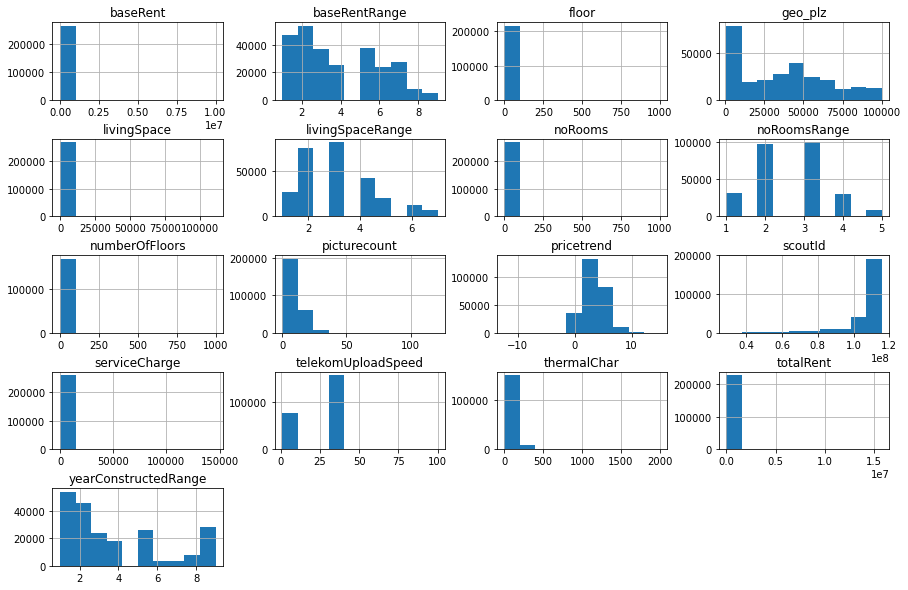

In [59]:
#Plot histograms of numeric features
_ = rentals.select_dtypes(numeric).hist(figsize = (15, 10))
plt.subplots_adjust(hspace= 0.5);

- The distributions of baseRent, floor, livingSpace, noRooms, numberOfFloors, serviceCharge, thermalChar and totalRent are highly skewed to the right.

### 5.6.1 scoutId and geo_plz 

- We first note that scoutId and geo_plz should be objects even though they have numerical representation
- scoutId is the identification number for the property
- geo_plz is the zip code for the property

In [60]:
#Convert scoutId and geo_plz to objects
rentals.scoutId = rentals.scoutId.astype('object')
rentals.geo_plz = rentals.geo_plz.astype('object')
rentals.dtypes['scoutId'], rentals.dtypes['geo_plz']

(dtype('O'), dtype('O'))

In [61]:
#Change geo_plz to zip_code
rentals = rentals.rename(columns = {'geo_plz': 'zip_code'})

### 5.6.2 Reviewing Range Information <br>(yearConstructedRange, baseRentRange, noRoomsRange, livingSpaceRange)</br>

- yearConstructedRange indicates binned construction years from 1 to 9. Determined that 21% of its values are missing, corresponding to the number of missing values for 'yearConstructed'. These are correlated features. Will drop this feature because it likely includes outliers.

- baseRentRange indicates binned base rent. Correlates directly with baseRent. Will drop this feature because it likely includes outliers.

- noRoomsRange indicates binned number of rooms 1 to 5. Redundant feature. Will drop this feature because it likely includes outliers.

- livingSpaceRange is the size of apartment sorted into 7 categories. Redundant feature. Will drop this feature because it likely includes outliers.

In [62]:
#Drop redundant features that may inlcude outliers
rentals.drop(columns = ['yearConstructedRange', 'baseRentRange', 'noRoomsRange', 'livingSpaceRange'], inplace = True)
rentals.select_dtypes(numeric).columns

Index(['serviceCharge', 'picturecount', 'pricetrend', 'telekomUploadSpeed',
       'totalRent', 'baseRent', 'livingSpace', 'noRooms', 'thermalChar',
       'floor', 'numberOfFloors'],
      dtype='object')

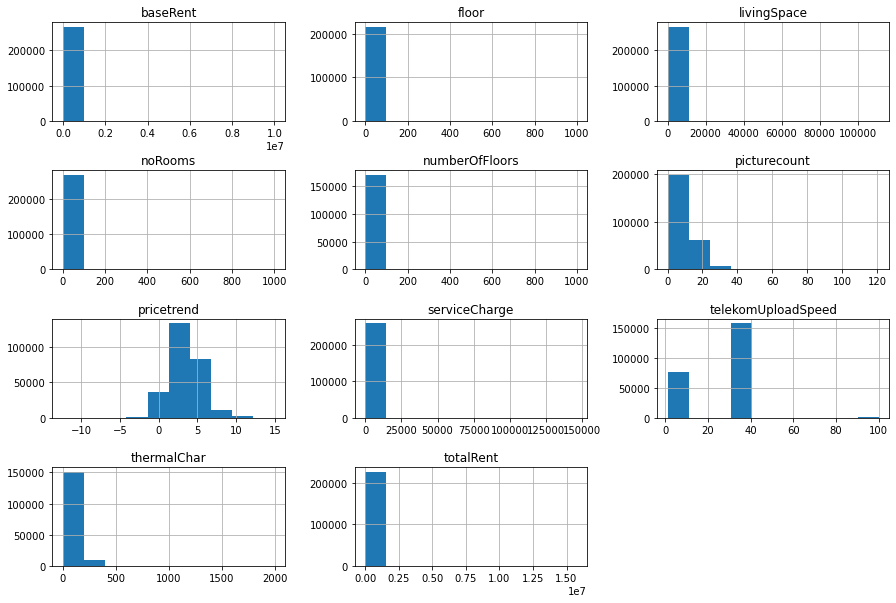

In [63]:
_ = rentals.select_dtypes(numeric).hist(figsize = (15, 10))
plt.subplots_adjust(hspace= 0.5);

### 5.6.3 Reviewing price-related information <br>(baseRent, totalRent, serviceCharge)</br>

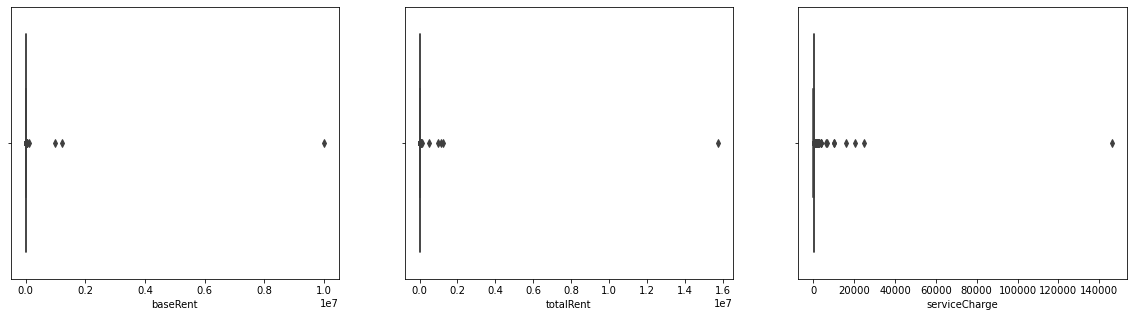

In [64]:
prices = ['baseRent', 'totalRent', 'serviceCharge']

fig, axes = plt.subplots(1, 3, figsize = [20,5])
for idx, price in enumerate(prices):
    _= sns.boxplot(x = price, data = rentals, ax= axes[idx])

In [65]:
#Review summary statistics for baseRent, totalRent and serviceCharge
rentals.baseRent.describe()

count    266576.00
mean        694.99
std       19617.76
min           0.00
25%         338.50
50%         490.00
75%         800.00
max     9999999.00
Name: baseRent, dtype: float64

In [66]:
rentals.totalRent.describe()

count     226424.00
mean         903.02
std        33378.13
min            0.00
25%          470.00
50%          650.00
75%          985.00
max     15751535.00
Name: totalRent, dtype: float64

In [67]:
rentals.serviceCharge.describe()

count   259722.00
mean       151.30
std        309.51
min          0.00
25%         95.00
50%        135.00
75%        190.00
max     146118.00
Name: serviceCharge, dtype: float64

- baseRent indicates the rent without electricity or heating. Has a min value of 0 and max value of 9M euros, likely outliers.

- totalRent includes baseRent, serviceCharge and heatingCosts. Determined ~ 15% of its values to be missing. Has min value of 0 euros and max value of 15,751,540 euros. Min and max values are extreme for rents.


- serviceCharge indicates ancillary costs such as electricity or internet. Previously determined that 2.6% of its values are missing. Has a min value of 0 euros and max value of 146,118.0 euros. These may be wrong data.

- We will capture values within three standard deviations from the mean and deem other values to be outliers

In [68]:
#Create function to create a mask that filters outliers
def outlier_remover(df, col_name):
    mean = df[col_name].mean()
    std = df[col_name].std()
    cut_off = 3 * std
    lower_limit, upper_limit = mean - cut_off, mean + cut_off
    mask = (df[col_name] > lower_limit) & (df[col_name] < upper_limit)
    return mask
    

In [69]:
#Filter-out outliers for price-related features
for price in prices:
    rentals[price] = rentals[price][outlier_remover(rentals, price)]

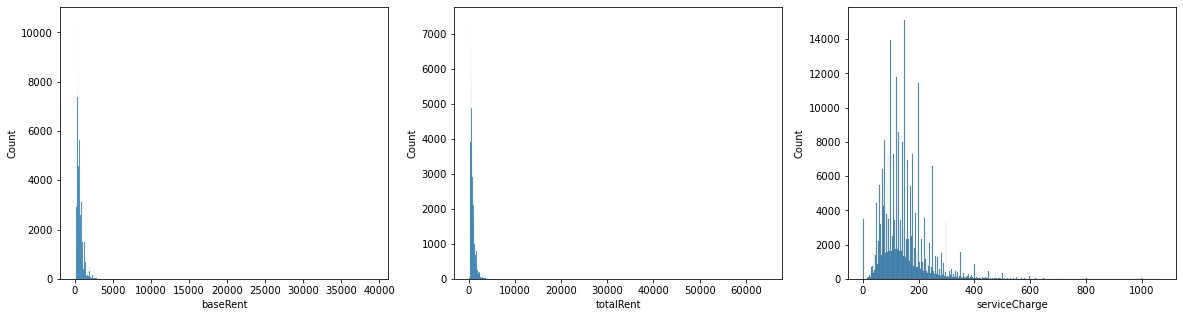

In [70]:
#Review distributions
fig, axes = plt.subplots(1, 3, figsize = [20,5])
for idx, price in enumerate(prices):
    _= sns.histplot(x = price, data = rentals, ax= axes[idx])

In [71]:
rentals.baseRent.describe()

count   266572.00
mean       648.65
std        516.87
min          0.00
25%        338.50
50%        490.00
75%        800.00
max      39200.00
Name: baseRent, dtype: float64

In [72]:
rentals.totalRent.describe()

count   226418.00
mean       815.90
std        612.03
min          0.00
25%        470.00
50%        650.00
75%        985.00
max      64651.00
Name: totalRent, dtype: float64

In [73]:
rentals.serviceCharge.describe()

count   259627.00
mean       149.91
std         84.09
min          0.00
25%         95.00
50%        135.00
75%        190.00
max       1070.00
Name: serviceCharge, dtype: float64

- Distributions are still right skewed, but there is a bit more spread than the original histograms. 

### Review Other Numeric Features
#### 5.6.4 picturecount 

- picturecount indicates how many pictures were loaded to the listing. Min of 0 and max of 121 makes sense. 


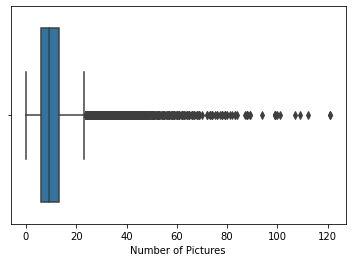

In [74]:
_= sns.boxplot(x = 'picturecount', data = rentals)
_= plt.xlabel('Number of Pictures')

#### 5.6.5 pricetrend 

- pricetrend is a parameter calculated by immoscout. Calculation or metric was not provided, however, it likely indicates the percentage change in price for that apartment or similar apartments in the area. Observed that ~ 0.7% of its values are missing. Has a min value of -12 and max value of 14.9. Range seems reasonable at first glance.


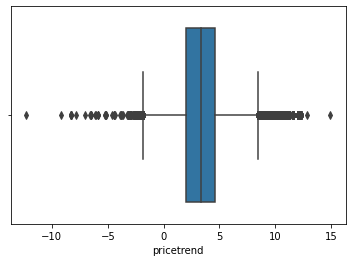

In [75]:
_= sns.boxplot(x = 'pricetrend', data = rentals)
_= plt.xlabel('pricetrend')

#### 5.6.6 telekomUploadSpeed 

- telekomUploadSpeed indicates internet upload speed. Determined that 12.4% of its values are missing. Unit not provided, but is typically measured in Mbps. Has seven values, with min speed of 1 and max speed of 100. Range seems reasonable at first glance. 


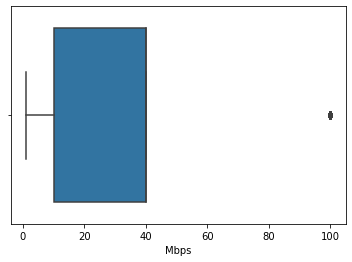

In [76]:
_= sns.boxplot(x = 'telekomUploadSpeed', data = rentals)
_= plt.xlabel('Mbps')

#### 5.6.7 livingSpace 

- livingSpace indicates living space in sqm. Min value of 0 and max value of 110,000 sqm, likely outliers.


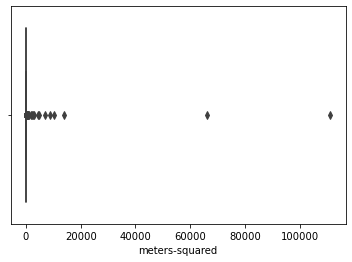

In [77]:
_= sns.boxplot(x = 'livingSpace', data = rentals)
_= plt.xlabel('meters-squared')

In [78]:
#Determine ideal upper and lower bounds for livingSpace if livingSpace was normally distributed
rentals.livingSpace.describe()

count   266576.00
mean        74.39
std        255.83
min          0.00
25%         54.00
50%         67.35
75%         87.00
max     111111.00
Name: livingSpace, dtype: float64

In [79]:
#Remove outliers
rentals.livingSpace = rentals.livingSpace[outlier_remover(rentals, 'livingSpace')]

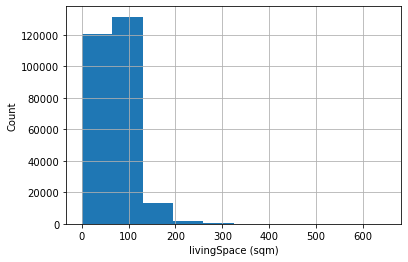

In [80]:
#Review distribution
rentals.livingSpace.hist()
_= plt.xlabel('livingSpace (sqm)')
_= plt.ylabel('Count')

In [81]:
rentals.livingSpace.describe()

count   266563.00
mean        73.50
std         32.13
min          0.00
25%         54.00
50%         67.35
75%         87.00
max        649.00
Name: livingSpace, dtype: float64

#### 5.6.8 noRooms 

- noRooms indicates number of rooms in apartment. Min value of 1. Max value of 999, likely an outlier. 

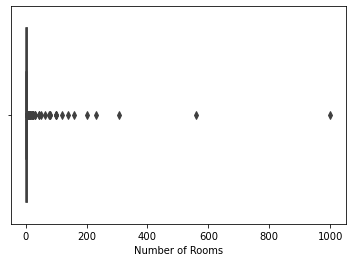

In [82]:
_= sns.boxplot(x = 'noRooms', data = rentals)
_= plt.xlabel('Number of Rooms')

- We notice units having more than 100 rooms.

In [83]:
#Remove outliers
rentals.noRooms = rentals.noRooms[outlier_remover(rentals, 'noRooms')]

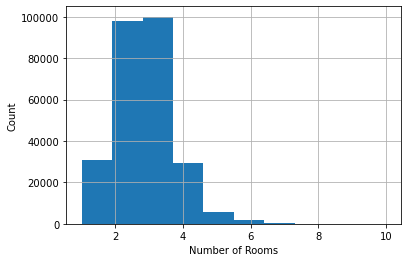

In [84]:
#Review distribution
_= rentals.noRooms.hist()
_= plt.xlabel('Number of Rooms')
_= plt.ylabel('Count')

In [85]:
rentals.noRooms.describe()

count   266520.00
mean         2.63
std          0.98
min          1.00
25%          2.00
50%          3.00
75%          3.00
max         10.00
Name: noRooms, dtype: float64

#### 5.6.9 thermalChar 

- thermalChar indicates energy demand of apartment. Data owner noted that it is used to determine energyEfficiencyClass. Has unit - kWh/(m^2a) [Kilowatt per square meter per annum] Determined that ~ 40% of its values are missing. Has a min value of 0.1 and max value of 1996. Values seem extreme. 


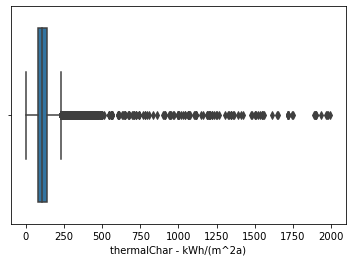

In [86]:
_= sns.boxplot(x = 'thermalChar', data = rentals)
_= plt.xlabel('thermalChar - kWh/(m^2a)')

In [87]:
#Remove outliers
rentals.thermalChar = rentals.thermalChar[outlier_remover(rentals, 'thermalChar')]

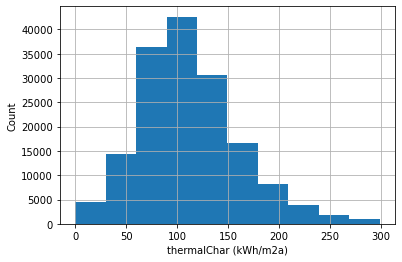

In [88]:
#Review distribution
_= rentals.thermalChar.hist()
_= plt.xlabel('thermalChar (kWh/m2a)')
_= plt.ylabel('Count')

#### 5.6.10 floor and numberOfFloors

- floor indicates floor number of apartment. Determined that 19% of its values are missing. Has 53 unique values, with min of -1 and max of 999. Min of -1 likely indicates a basement apartment, but a max of 999 is an extreme value. Floor number is an identifier for the apartment specific to the building.
- numberOfFloors indicates the number of floors in the building. Has 57 unique values, with min of 0 and max of 999, similar to 'floor'. 999 is an extreme values.

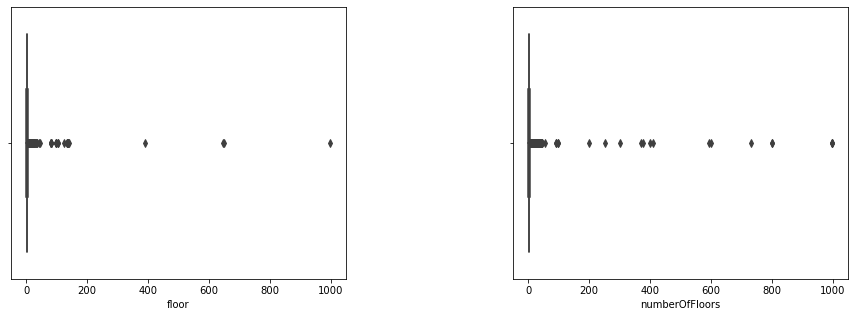

In [89]:
fig, ax = plt.subplots(nrows = 1,ncols = 2, figsize=(15, 5))
_= sns.boxplot(x = 'floor', data = rentals, ax = ax[0])
_= sns.boxplot(x = 'numberOfFloors', data = rentals, ax = ax[1])
plt.subplots_adjust(wspace= 0.5)
plt.show()

- Tallest German building has 56 floors. We will filter with this limit. Also we note that the numberOfFloors provides a relates better to price than the number of the floor. We will drop floor.

In [90]:
#Drop floor
rentals.drop('floor', axis =1, inplace = True)

In [91]:
#Remove outliers in numberOfFloors
rentals.numberOfFloors = rentals.numberOfFloors[outlier_remover(rentals, 'numberOfFloors')]

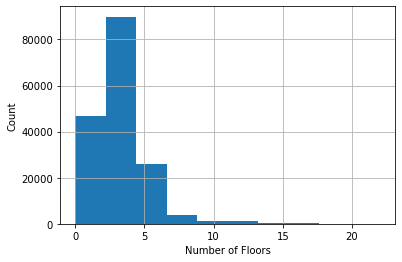

In [92]:
#Review distribution
_= rentals.numberOfFloors.hist()
_= plt.xlabel('Number of Floors')
_= plt.ylabel('Count')

## 5.7 Review of Boolean Features

In [93]:
rentals.select_dtypes('boolean').head()

,newlyConst,balcony,hasKitchen,cellar,lift,garden
0,False,False,False,True,False,True
1,False,True,False,False,False,False
2,True,True,False,True,True,False
3,False,True,False,False,False,False
4,False,True,False,False,False,False


In [94]:
#Review missing values
rentals.select_dtypes('boolean').isna().sum()

newlyConst    0
balcony       0
hasKitchen    0
cellar        0
lift          0
garden        0
dtype: int64

## 5.8 Review Datatime Features 

In [95]:
rentals.select_dtypes('datetime').head()

,yearConstructed,date
0,1965-01-01,2019-05-01
1,1871-01-01,2019-05-01
2,2019-01-01,2019-10-01
3,1964-01-01,2019-05-01
4,1950-01-01,2020-02-01


### 5.8.1 yearConstructed

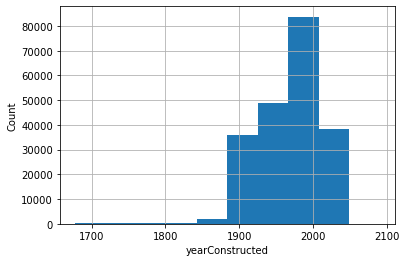

In [96]:
#Plot distribution
_ = rentals.yearConstructed.dt.year.hist()
_= plt.xlabel('yearConstructed')
_= plt.ylabel('Count')

- There are dates past 2020

In [97]:
rentals[rentals.yearConstructed.dt.year > 2020]

,state,serviceCharge,heatingType,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,firingTypes,hasKitchen,cellar,baseRent,livingSpace,condition,interiorQual,petsAllowed,lift,typeOfFlat,zip_code,noRooms,thermalChar,numberOfFloors,garden,district,town_municipality,date
34708,Hessen,570.00,central_heating,NaN,True,True,4,3.82,nan,3780.00,2021-01-01,115366492,NaN,False,False,3210.00,225.00,first_time_use,NaN,NaN,False,NaN,61462,5.00,nan,nan,False,Hochtaunuskreis,Königstein_im_Taunus,2020-02-01
40265,Berlin,120.00,district_heating,NaN,True,False,9,6.29,nan,590.00,2029-01-01,114977577,NaN,True,True,470.00,31.00,first_time_use,sophisticated,no,True,apartment,12487,1.00,nan,5.00,False,Berlin,Johannisthal_Treptow,2020-02-01
46273,Mecklenburg_Vorpommern,209.35,district_heating,NaN,True,True,12,1.13,nan,1096.27,2021-01-01,114078269,district_heating,False,False,886.92,84.00,first_time_use,NaN,NaN,False,NaN,17489,3.00,nan,nan,False,Greifswald,Innenstadt,2020-02-01
54595,Hessen,440.00,floor_heating,ONE_YEAR_FREE,True,False,14,4.48,40.00,3385.00,2026-01-01,113807419,NaN,True,False,2945.00,156.13,mint_condition,NaN,negotiable,True,apartment,60594,4.00,59.00,6.00,False,Frankfurt_am_Main,Sachsenhausen_Nord,2019-10-01
71178,Brandenburg,130.00,solar_heating,NaN,True,True,0,4.27,nan,617.00,2022-01-01,114344635,solar_heating,False,False,487.00,65.00,first_time_use,sophisticated,NaN,False,other,16359,3.00,nan,2.00,True,Barnim,Biesenthal,2020-02-01
79691,Mecklenburg_Vorpommern,201.68,district_heating,NaN,True,True,12,1.13,nan,1032.01,2021-01-01,114461937,district_heating,False,False,830.33,81.00,first_time_use,NaN,NaN,False,NaN,17489,3.00,nan,nan,False,Greifswald,Innenstadt,2020-02-01
87221,Baden_Württemberg,250.00,district_heating,ONE_YEAR_FREE,True,True,10,3.96,40.00,1475.00,2090-01-01,110659704,district_heating,False,True,1175.00,130.64,mint_condition,NaN,no,True,ground_floor,76437,4.00,53.00,nan,False,Rastatt,Rastatt,2019-05-01
96883,Schleswig_Holstein,nan,NaN,ONE_YEAR_FREE,True,False,6,3.30,40.00,nan,2021-01-01,115522305,NaN,True,False,630.00,60.00,NaN,sophisticated,NaN,True,NaN,24972,2.00,nan,nan,True,Schleswig_Flensburg,Steinbergkirche,2020-02-01
101493,Hessen,420.00,central_heating,NaN,True,True,4,3.82,nan,2730.00,2021-01-01,115366568,NaN,False,False,2310.00,165.00,first_time_use,NaN,NaN,False,NaN,61462,4.00,nan,nan,False,Hochtaunuskreis,Königstein_im_Taunus,2020-02-01
118686,Schleswig_Holstein,nan,central_heating,NaN,True,True,5,2.67,nan,nan,2021-01-01,115420487,gas,True,False,495.00,49.00,first_time_use,sophisticated,negotiable,True,apartment,25715,2.00,26.70,2.00,False,Dithmarschen,Brunsbüttel,2020-02-01


- We observe than many of the units are first-time use. However, we also notice that those units with mint condition have yearConstructed dates that are further out. We will remove these rows.

In [98]:
#Filter-out outliers
rentals = rentals[~((rentals.yearConstructed.dt.year > 2020) & (rentals.condition == 'mint_condition'))]

## 5.9 State-wide Features

### 5.9.2 State Profile

In [99]:
#Load German states information
states_url = 'https://en.wikipedia.org/wiki/States_of_Germany'
german_states = pd.read_html(states_url)

In [100]:
states = german_states[5]
states

,Coat of arms,Flag,State,Since,Capital,Legislature,Head of government,Governmentcoalition,Bundesrat votes,Area(km2),Population(Dec. 2019)[7],Pop.per km2,HDI(2018)[8],ISO3166-2code,GDP per capita in Euro (2018)[9]
0,nan,nan,Baden-Württemberg,1952[10],Stuttgart,Landtag of Baden-Württemberg,Winfried Kretschmann (Greens),"Greens, CDU",6,35752,11100394,310,0.95,BW,47290
1,nan,nan,Bavaria(Bayern),1949,Munich(München),Landtag of Bavaria,Markus Söder (CSU),"CSU, FW",6,70552,13124737,185,0.95,BY,48323
2,nan,nan,Berlin,1990[11],–,Abgeordnetenhaus,Michael Müller (SPD),"SPD, The Left, Greens",4,892,3669491,4086,0.95,BE,41967
3,nan,nan,Brandenburg,1990,Potsdam,Landtag of Brandenburg,Dietmar Woidke (SPD),"SPD, CDU, Greens",4,29479,2521893,85,0.91,BB,29541
4,nan,nan,Bremen,1949,Bremen,Bürgerschaft of Bremen,Andreas Bovenschulte (SPD),"SPD, Greens, The Left",3,419,681202,1630,0.95,HB,49215
5,nan,nan,Hamburg,1949,–,Bürgerschaft of Hamburg,Peter Tschentscher (SPD),"SPD, Greens",3,755,1847253,2439,0.97,HH,66879
6,nan,nan,Hesse(Hessen),1949,Wiesbaden,Landtag of Hesse,Volker Bouffier (CDU),"CDU, Greens",5,21115,6288080,297,0.95,HE,46923
7,nan,nan,Lower Saxony(Niedersachsen),1949,Hanover(Hannover),Landtag of Lower Saxony,Stephan Weil (SPD),"SPD, CDU",6,47609,7993448,168,0.92,NI,38423
8,nan,nan,Mecklenburg-Vorpommern,1990,Schwerin,Landtag of Mecklenburg-Vorpommern,Manuela Schwesig (SPD),"SPD, CDU",3,23180,1609675,69,0.91,MV,28940
9,nan,nan,North Rhine-Westphalia(Nordrhein-Westfalen),1949,Düsseldorf,Landtag of North Rhine-Westphalia,Armin Laschet (CDU),"CDU, FDP",6,34085,17932651,526,0.94,NW,39678


In [101]:
state_features = states[['State', 'Area(km2)', 'Population(Dec. 2019)[7]', 'Pop.per km2', 'GDP per capita in Euro (2018)[9]', 'HDI(2018)[8]']]
state_features.head()

,State,Area(km2),Population(Dec. 2019)[7],Pop.per km2,GDP per capita in Euro (2018)[9],HDI(2018)[8]
0,Baden-Württemberg,35752,11100394,310,47290,0.95
1,Bavaria(Bayern),70552,13124737,185,48323,0.95
2,Berlin,892,3669491,4086,41967,0.95
3,Brandenburg,29479,2521893,85,29541,0.91
4,Bremen,419,681202,1630,49215,0.95


In [102]:
state_features.columns = ['State', 'area_km2', 'population_2019', 'population_per_km2', 'gdp_per_capita_2018', 'hdi']
state_features.head()

,State,area_km2,population_2019,population_per_km2,gdp_per_capita_2018,hdi
0,Baden-Württemberg,35752,11100394,310,47290,0.95
1,Bavaria(Bayern),70552,13124737,185,48323,0.95
2,Berlin,892,3669491,4086,41967,0.95
3,Brandenburg,29479,2521893,85,29541,0.91
4,Bremen,419,681202,1630,49215,0.95


In [103]:
#Load German states information
path_economic = 'https://en.wikipedia.org/wiki/List_of_German_states_by_GRP'
state_economic = pd.read_html(path_economic)

In [104]:
economy_2020 = state_economic[0]
economy_2020.head()

,States,Rank,GRP (in billions EUR€),Share of GDP (%),Comparable economy
0,Germany,—,3332.23,100.00,-
1,North Rhine-Westphalia,1,697.13,20.90,Switzerland
2,Bavaria,2,610.22,18.30,Switzerland
3,Baden-Württemberg,3,500.79,15.00,Sweden
4,Lower Saxony,4,295.90,8.90,Denmark


In [105]:
economy_2019 = state_economic[1]
economy_2019.head()

,States,Rank,GRP (in billions EUR€),Share of GDP (%),Comparable economy
0,Germany,—,3435.76,100.00,-
1,North Rhine-Westphalia,1,711.42,21.20,Netherlands
2,Bavaria,2,632.90,18.20,Switzerland
3,Baden-Württemberg,3,524.33,15.10,Poland
4,Lower Saxony,4,307.04,8.80,Denmark


In [106]:
rentals.shape

(266572, 30)

## 5.10 Target feature 

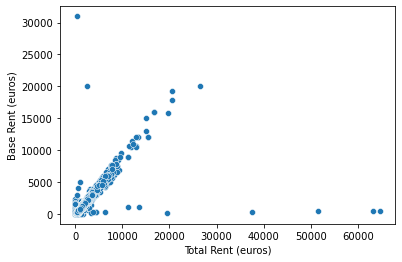

In [107]:
_= sns.scatterplot(x = 'totalRent', y = 'baseRent', data = rentals)
_= plt.xlabel('Total Rent (euros)')
_= plt.ylabel('Base Rent (euros)')

In [108]:
rentals['baseRent_per_sqm'] = rentals['baseRent'] / rentals['livingSpace']
rentals['totalRent_per_sqm'] = rentals['totalRent'] / rentals['livingSpace']
rentals[['baseRent', 'baseRent_per_sqm', 'totalRent', 'totalRent_per_sqm', 'livingSpace']].head()

,baseRent,baseRent_per_sqm,totalRent,totalRent_per_sqm,livingSpace
0,595.00,6.92,840.00,9.77,86.00
1,800.00,8.99,nan,nan,89.00
2,965.00,11.52,1300.00,15.51,83.80
3,343.00,5.90,nan,nan,58.15
4,765.00,9.00,903.00,10.63,84.97


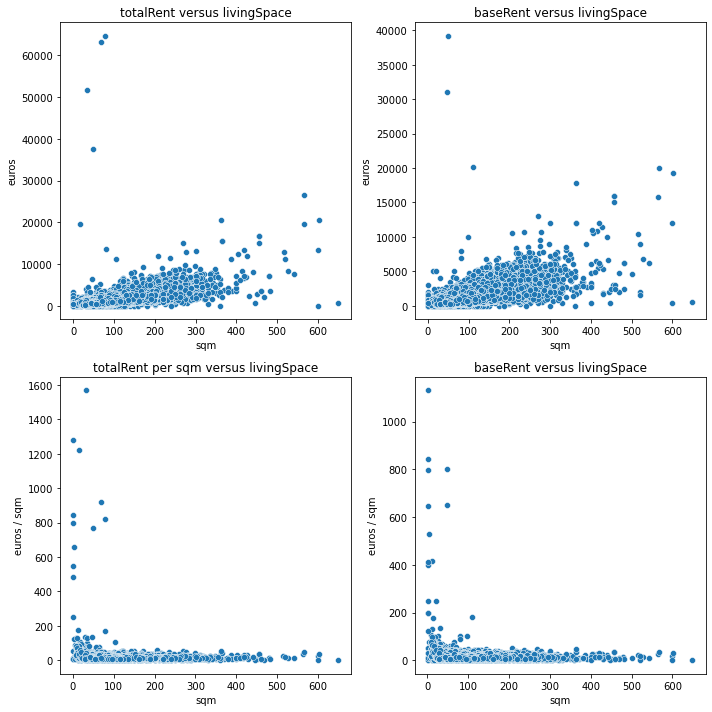

In [109]:
fig, ax = plt.subplots(figsize = (10, 10))

plt.subplot(2,2, 1)
_= sns.scatterplot(x = 'livingSpace', y = 'totalRent', data = rentals)
_= plt.xlabel('sqm')
_= plt.ylabel('euros')
_= plt.title('totalRent versus livingSpace')

plt.subplot(2,2, 2)
_= sns.scatterplot(x = 'livingSpace', y = 'baseRent', data = rentals)
_= plt.xlabel('sqm')
_= plt.ylabel('euros')
_= plt.title('baseRent versus livingSpace')

plt.subplot(2,2, 3)
_= sns.scatterplot(x = 'livingSpace', y = 'totalRent_per_sqm', data = rentals)
_= plt.xlabel('sqm')
_= plt.ylabel('euros / sqm')
_= plt.title('totalRent per sqm versus livingSpace')

plt.subplot(2,2, 4)
_= sns.scatterplot(x = 'livingSpace', y = 'baseRent_per_sqm', data = rentals)
_= plt.xlabel('sqm')
_= plt.ylabel('euros / sqm')
_= plt.title('baseRent versus livingSpace')

fig.tight_layout()
plt.show()

In [111]:
rentals.baseRent_per_sqm.describe()

count   266545.00
mean          inf
std           nan
min          0.00
25%          5.62
50%          7.38
75%         10.18
max           inf
Name: baseRent_per_sqm, dtype: float64

In [ ]:
_= sns.scatterplot(x = 'livingSpace', y = 'baseRent_per_sqm', data = rentals)
_= plt.xlabel('sqm')
_= plt.ylabel('euros / sqm')
_= plt.title('baseRent versus livingSpace')

# 6. Saving New Dataframe

In [ ]:
datapath = '..\data\processed'
# renaming the output data directory and re-running this notebook, for example,
# will recreate this (empty) directory and resave the data files.
# NB this is not a substitute for a modern data pipeline, for which there are
# various tools. However, for our purposes here, and often in a "one off" analysis,
# this is useful because we have to deliberately move/delete our data in order
# to overwrite it.
if not os.path.exists(datapath):
    os.mkdir(datapath)

In [ ]:
datapath_rentals = os.path.join(datapath, 'rentals_cleaned4.csv')
if not os.path.exists(datapath_rentals):
    rentals.to_csv(datapath_rentals, index=False)

In [ ]:
datapath_state_features = os.path.join(datapath, 'state_features.csv')
if not os.path.exists(datapath_state_features):
    state_features.to_csv(datapath_state_features, index=False)